In [1]:
import numpy as np
from astropy.io import fits

%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


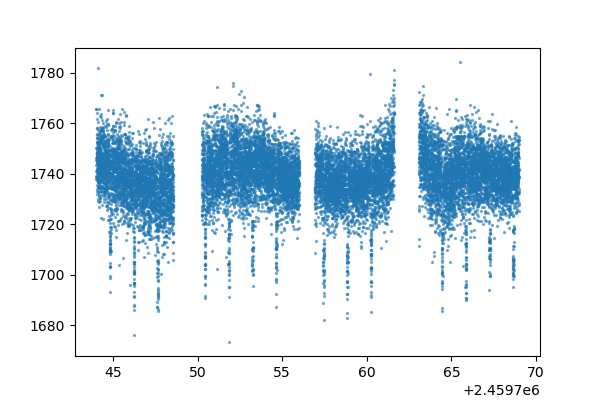

In [2]:
data = np.genfromtxt('target_PDCSAPflux_3.dat')

time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]

plt.figure(figsize=(6,4))
plt.scatter(time, flux, s=2, alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


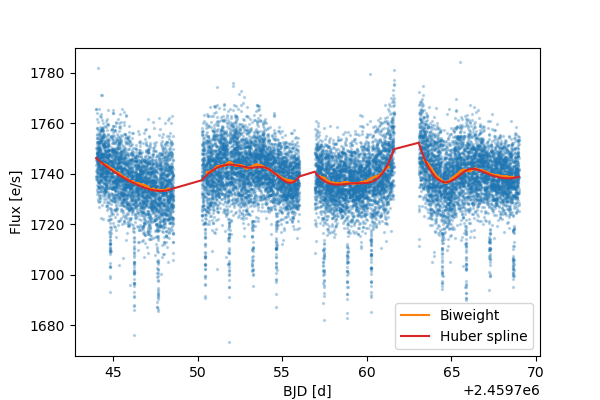

In [3]:
from wotan import flatten

flatten_bw, trend_bw = flatten(
    time[:],                 # Array of time values
    flux[:],                 # Array of flux values
    method='biweight',
    window_length=1.0,    # The length of the filter window in units of ``time``
    edge_cutoff=0.3,      # length (in units of time) to be cut off each edge.
    break_tolerance=0.5,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    cval=5.0              # Tuning parameter for the robust estimators
    )


flatten_hs, trend_hs = flatten(
    time[:],                 # Array of time values
    flux[:],                 # Array of flux values
    method='hspline',
    window_length=0.8,    # The length of the filter window in units of ``time``
    break_tolerance=0.5,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    cval=1.5              # Tuning parameter for the robust estimators
    )



plt.figure(figsize=(6,4))
plt.scatter(time, flux, s=2, alpha=0.25)

plt.plot(time, trend_bw, c='C1', label='Biweight')
plt.plot(time, trend_hs, c='C3', label='Huber spline')

plt.xlabel('BJD [d]')
plt.ylabel('Flux [e/s]')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


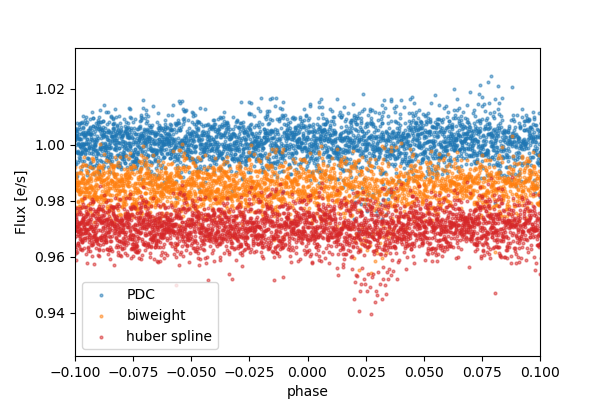

In [4]:
plt.figure(figsize=(6,4))

period = 2.61585922
time_of_transit = 2455565.546480

phase_lims = [0.15, 0.35]

phase =  ((time - time_of_transit - period/2) / period) % 1 - 0.5
#phase =  ((time - time_of_transit) / period) % 1

# Normalization factor for PDCSAP
PDC_sel_normalization = ((np.abs(phase) > phase_lims[0]) & ((np.abs(phase) < phase_lims[1])))
PDC_norm_factor = np.nanmedian(flux[PDC_sel_normalization])

normalized_PDC = flux/PDC_norm_factor
plt.scatter(phase, normalized_PDC, s=4, c='C0', alpha=0.5, label='PDC')

plt.scatter(phase, flatten_bw - 0.015, c='C1', s=4, label='biweight', alpha=0.5)
plt.scatter(phase, flatten_hs - 0.030, c='C3', s=4, label='huber spline', alpha=0.5)

plt.xlim(-0.1, 0.1)
plt.xlabel('phase')
plt.ylabel('Flux [e/s]')

plt.legend()
plt.show()

In [5]:
sel = (np.abs(phase) > 0.05) & (np.abs(phase) < 0.10) & (~np.isnan(flatten_bw)) & (~np.isnan(flatten_hs))
print('PDCSAP STD:   {0:12f}'.format(np.std(normalized_PDC[sel])))
print('biweight STD: {0:12f}'.format(np.std(flatten_bw[sel])))
print('Huber STD:    {0:12f}'.format(np.std(flatten_hs[sel])))

PDCSAP STD:       0.005389
biweight STD:     0.005181
Huber STD:        0.005176


In [6]:

fileout = open('target_PDCSAP_flattened_biweight_3.dat', 'w') 

for t, f, e in zip(time, flatten_bw, flux_err/trend_bw):
    if np.isnan(f): continue
    # TRICK
    fileout.write('{0:17.7f} {1:14f} {2:14f} 0 -1 -1 \n'.format(t, f, e))

fileout.close()



In [7]:
#Remember to save the TASTE differential lighcurve in the same format as the flattened light curve.